In [133]:
with open('names.txt', 'r') as f:
    words = f.read().split()

words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [134]:
len(words)

32033

In [135]:
min(len(w) for w in words), max(len(w) for w in words)

(2, 15)

## BIGRAM MODEL

Use one character to predict the next one.

In [136]:
b = dict()
for w in words:
    w = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [137]:
sorted(b.items(), key=lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [138]:
import torch

In [139]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [140]:
stoi.items()

dict_items([('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10), ('k', 11), ('l', 12), ('m', 13), ('n', 14), ('o', 15), ('p', 16), ('q', 17), ('r', 18), ('s', 19), ('t', 20), ('u', 21), ('v', 22), ('w', 23), ('x', 24), ('y', 25), ('z', 26), ('.', 0)])

In [141]:
N = torch.zeros((28, 28), dtype=torch.int32)

for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        ich1 = stoi.get(ch1)
        ich2 = stoi.get(ch2)
        N[ich1, ich2] += 1

In [142]:
itos = {i:s for s,i in stoi.items()}
len(itos)

27

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

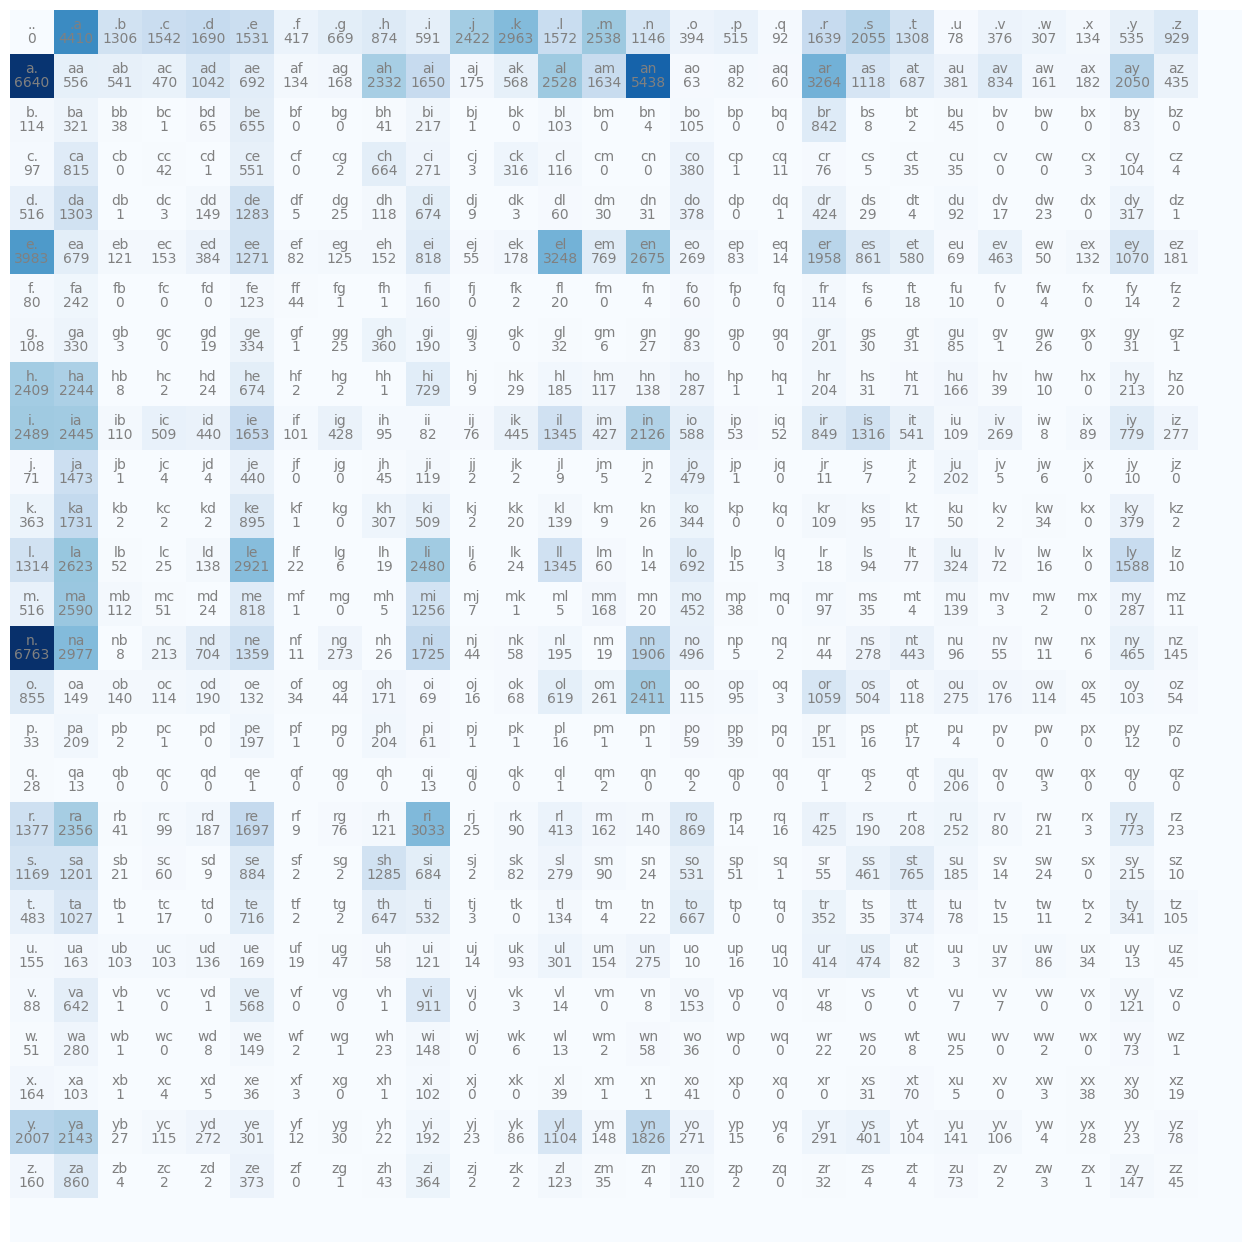

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Blues")

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis("off")

In [144]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [145]:
g = torch.Generator().manual_seed(143)

ix = 0
name = ""
while True:
    p = P[ix]
    ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
    char = itos[ix]
    name += char
    print(name)
    if ix == 0:
        break

h
hi
hia
hiat
hiath
hiath.


In [146]:
log_likelihood = 0.0
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        ich1 = stoi.get(ch1)
        ich2 = stoi.get(ch2)
        prob = P[ich1, ich2]
        log_prob = torch.log(prob)
        log_likelihood += log_prob

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")

log_likelihood=tensor(-559978.7500)
nll=tensor(559978.7500)


In [147]:
log_likelihood = 0.0
for w in ['andrejq']:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        ich1 = stoi.get(ch1)
        ich2 = stoi.get(ch2)
        prob = P[ich1, ich2]
        print(f"{ch1}{ch2} {prob:.4f}")
        log_prob = torch.log(prob)
        log_likelihood += log_prob

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")

.a 0.1376
an 0.1604
nd 0.0384
dr 0.0769
re 0.1334
ej 0.0027
jq 0.0003
q. 0.0967
log_likelihood=tensor(-27.8713)
nll=tensor(27.8713)


## Neural Network Setting

In [148]:
# Create training set
xs, ys = [], []
for w in words[:10]:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        ich1 = stoi.get(ch1)
        ich2 = stoi.get(ch2)
        xs.append(ich1)
        ys.append(ich2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [149]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape

torch.Size([67, 27])

In [150]:
W = torch.randn((27,27), generator=g, requires_grad=True)

In [151]:
for e in range(10):

    # forward pass
    logits = xenc @ W #log-counts
    counts = logits.exp() # Similar to counts or N 
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(xenc.shape[0]), ys].log().mean()
    print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()
    W.data += -50 * W.grad

3.7380144596099854
2.58974552154541
2.090486526489258
1.8566118478775024
1.6934685707092285
1.6245689392089844
1.500627040863037
1.4800689220428467
1.4318009614944458
1.452236533164978


In [159]:
g = torch.Generator().manual_seed(143)

ix = 0
name = ""
while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W #log-counts
    counts = logits.exp() # Similar to counts or N 
    p = counts / counts.sum(dim=1, keepdim=True)
    ix = torch.multinomial(p, 1, replacement=True).item()
    char = itos[ix]
    name += char
    print(name)
    if ix == 0:
        break

s
sa
sam
samm
sammo
sammot
sammott
sammottt
sammotttt
sammotttte
sammottttei
sammotttteis
sammotttteiso
sammotttteisol
sammotttteisoll
sammotttteisolli
sammotttteisollia
sammotttteisolliae
sammotttteisolliaem
sammotttteisolliaemm
sammotttteisolliaemma
sammotttteisolliaemma.
